In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import statsmodels.api as sm

In [3]:
np.random.seed(0)
a = np.random.rand(100)
b = np.random.rand(100)
c = np.random.rand(100)

In [4]:
y = np.random.poisson(np.exp(1.5*a + -1*b + 0.5*c))

In [5]:
df = pd.DataFrame(zip(y, a, b, c), columns=['y', 'a', 'b', 'c'])

In [6]:
df.head()

,y,a,b,c
0,2,0.548814,0.677817,0.311796
1,1,0.715189,0.270008,0.696343
2,0,0.602763,0.735194,0.377752
3,0,0.544883,0.962189,0.179604
4,0,0.423655,0.248753,0.024679


<AxesSubplot:ylabel='Frequency'>

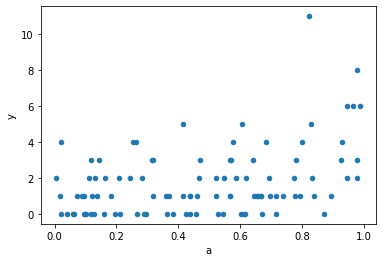

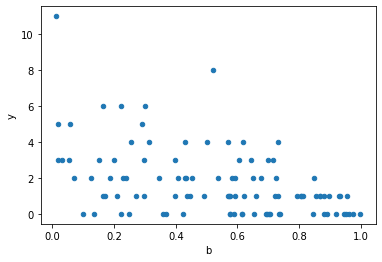

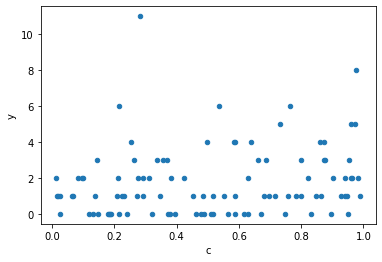

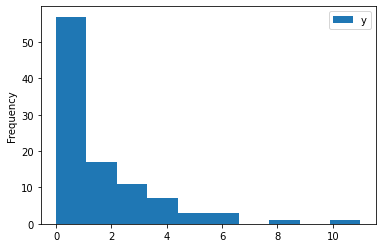

In [7]:
df.plot(kind='scatter', x='a', y='y')
df.plot(kind='scatter', x='b', y='y')
df.plot(kind='scatter', x='c', y='y')
df.plot(kind='hist', y='y')

# パッケージ

In [8]:
model = sm.GLM(df['y'], df[[ 'a', 'b', 'c']], family=sm.families.Poisson())

In [9]:
results = model.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -154.45
Date:                Sat, 25 Jun 2022   Deviance:                       121.10
Time:                        15:13:18   Pearson chi2:                     125.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.5323
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
a              1.5747      0.204      7.704      0.0

# 損失関数を負の対数尤度として解く
- SGD
- 最急降下法
- ニュートン法

目的変数がポアソン分布に従ってると仮定する。
$$
    y_i \sim poisson(\lambda_i), \lambda_i = \exp{(\beta_1x_{1i} + \beta_2x_{2i})}
$$
尤度関数は以下。
$$
    Likelihood = \Pi \frac{\lambda_i^{y_i}\exp(-\lambda_i)}{y_i!}
$$
負の対数尤度を損失関数とする。
$$
    L = -\sum_i^n y\log{\lambda_i} - \lambda_i - \log{y_i!}
$$

損失関数の1階微分を計算する。簡単のため1サンプルで1階微分を計算する。

$$
    \frac{dL}{d\lambda} = 1 - \frac{y}{\lambda}, \frac{d\lambda}{d\beta_1} = \exp{(\beta_1x_1+\beta_2x_2)}x_1より \\
    \frac{dL}{d\beta_1} = \frac{dL}{d\lambda}\frac{d\lambda}{d\beta_1} = \lambda x_1 - yx_1 \quad （\lambda = \exp{(\beta_1x_1 + \beta_2x_2)}を利用した)
$$

あとは同様にパラメータを更新する。

ニュートン法のために2階微分も求めておく。
$$
    \frac{dL}{d\beta_1\beta_1} =  \lambda x_1^2, \frac{dL}{d\beta_1\beta_2} = \lambda x_1x_2
$$
これも同様にパラメータを更新する。

In [10]:
def negative_loglikelihood(Y, lambda_hat):
    return -np.sum(Y*np.log(lambda_hat)-lambda_hat)

In [11]:
X = df[[ 'a', 'b', 'c']].values
Y = df['y'].values

In [12]:
alpha = 0.01

### SGD

In [13]:
def negative_loglikelihood_grad_sgd(y, x, beta):
    lambda_hat = np.exp(np.sum(x*beta))
    return lambda_hat*x - y*x

In [14]:
# 初期化
np.random.seed(0)
init_beta = np.random.rand(3)
print("初期パラメータ: ", init_beta)

初期パラメータ:  [0.5488135  0.71518937 0.60276338]


In [15]:
beta = init_beta
# パラメータ更新
beta_result = []
loss_result = []
for i in range(100):
    for x, y in zip(X, Y):
        beta = beta - alpha*negative_loglikelihood_grad_sgd(y, x, beta)
        lambda_hat = np.exp(np.sum(X*beta, axis=1))
        # save
        beta_result.append(list(beta))
        loss_result.append([i+1, negative_loglikelihood(Y, lambda_hat)])
print("パラメータ: ", beta)
beta_result = np.array(beta_result)
loss_result = np.array(loss_result)

パラメータ:  [ 1.58752474 -1.47774531  0.73701154]


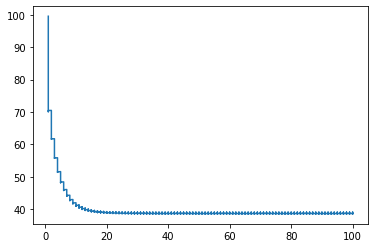

In [16]:
# loss関数の推移
plt.plot(loss_result[:, 0], loss_result[:, 1])

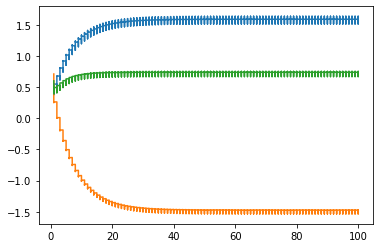

In [17]:
# パラメータの推移
plt.plot(loss_result[:, 0], beta_result[:, 0])
plt.plot(loss_result[:, 0], beta_result[:, 1])
plt.plot(loss_result[:, 0], beta_result[:, 2])

### 最急降下法

In [18]:
def negative_loglikelihood_grad(Y, X, beta):
    lambda_hat = np.exp(np.sum(X*beta, axis=1))
    return np.sum(lambda_hat.reshape(-1, 1) * X - Y.reshape(-1, 1)*X, axis=0)

In [19]:
# 初期化
np.random.seed(0)
init_beta = np.random.rand(3)
print("初期パラメータ: ", init_beta)

初期パラメータ:  [0.5488135  0.71518937 0.60276338]


In [20]:
beta = init_beta
# パラメータ更新
beta_result = []
loss_result = []
for i in range(50):
    beta = beta - alpha*negative_loglikelihood_grad(Y, X, beta)
    lambda_hat = np.exp(np.sum(X*beta, axis=1))
    # save
    beta_result.append(list(beta))
    loss_result.append([i+1, negative_loglikelihood(Y, lambda_hat)])
print("パラメータ: ", beta)
beta_result = np.array(beta_result)
loss_result = np.array(loss_result)

パラメータ:  [ 1.57389517 -1.53105638  0.73082097]


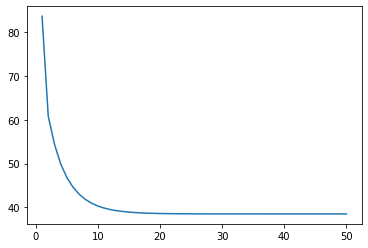

In [21]:
# loss関数の推移
plt.plot(loss_result[:, 0], loss_result[:, 1])

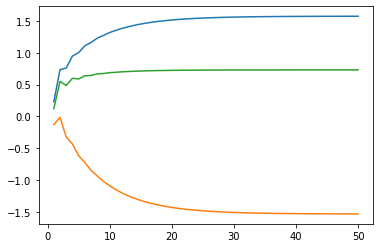

In [22]:
# パラメータの推移
plt.plot(loss_result[:, 0], beta_result[:, 0])
plt.plot(loss_result[:, 0], beta_result[:, 1])
plt.plot(loss_result[:, 0], beta_result[:, 2])

### ニュートン法

In [23]:
# 1サンプルに対してhessを計算する
def negative_loglikelihood_hess_sgd(x, beta):
    lambda_hat = np.exp(np.sum(x*beta))
    return  lambda_hat * x.reshape(-1, 1).dot(x.reshape(1, -1))

In [27]:
def negative_loglikelihood_hess(X, beta):
    hess = np.zeros((X.shape[1], X.shape[1]))
    for x in X:
        hess += negative_loglikelihood_hess_sgd(x, beta)
    return hess

In [28]:
# 初期化
np.random.seed(0)
init_beta = np.random.rand(3)
print("初期パラメータ: ", init_beta)
init_loss = negative_loglikelihood(Y, np.exp(np.sum(X*init_beta, axis=1)))

初期パラメータ:  [0.5488135  0.71518937 0.60276338]


In [29]:
beta = init_beta
# パラメータ更新
beta_result = [list(init_beta)]
loss_result = [[0, init_loss]]
for i in range(10):
    grad = negative_loglikelihood_grad(Y, X, beta)
    hess = negative_loglikelihood_hess(X, beta)
    beta = beta - (np.linalg.inv(hess).dot(grad))
    lambda_hat = np.exp(np.sum(X*beta, axis=1))
    # save
    beta_result.append(list(beta))
    loss_result.append([i+1, negative_loglikelihood(Y, lambda_hat)])
print("パラメータ: ", beta)
beta_result = np.array(beta_result)
loss_result = np.array(loss_result)

パラメータ:  [ 1.57472446 -1.5324384   0.73087205]


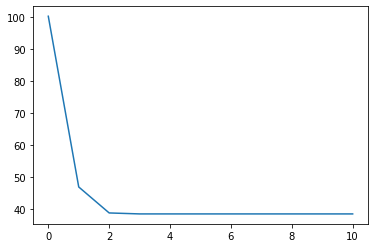

In [30]:
# loss関数の推移
plt.plot(loss_result[:, 0], loss_result[:, 1])

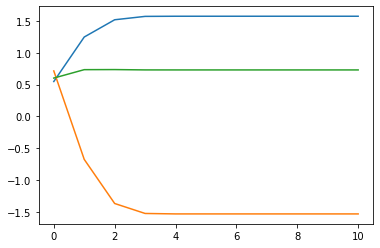

In [31]:
# パラメータの推移
plt.plot(loss_result[:, 0], beta_result[:, 0])
plt.plot(loss_result[:, 0], beta_result[:, 1])
plt.plot(loss_result[:, 0], beta_result[:, 2])